In [1]:
import numpy as np
import gwsurrogate
import matplotlib.pyplot as plt
%matplotlib inline
from pycbc.types import TimeSeries

/home/rudall/miniconda3/envs/ringdown/lib/python3.10/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/rudall/miniconda3/envs/ringdown/lib/python3.10/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [2]:
# This can take a few minutes
#gwsurrogate.catalog.pull('NRHybSur3dq8')

In [3]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
type(sur)

Loaded NRHybSur3dq8 model


gwsurrogate.surrogate.NRHybSur3dq8

In [4]:
q = 1
chiA = [0, 0, 0]
chiB = [0, 0, 0]
f_low = 0  # this will be ignored and the wavefrom will be returned on the times given below
times = np.arange(-10000,130,0.1)
# The returned times are the same as the input times
times, h, dyn = sur(q, chiA, chiB, times=times, f_low=f_low)
print(h[(2,2)])

[7.85207906e-02+0.00000000e+00j 7.85207497e-02-1.87547729e-04j
 7.85202609e-02-3.75095937e-04j ... 1.49585322e-05-1.48971767e-05j
 1.26867753e-05-1.55188599e-05j 1.04385665e-05-1.58564611e-05j]


In [5]:
def wrap_surrogate_to_pycbc(
    sur,
    mass_1,
    mass_2,
    spin_1x=0,
    spin_1y=0,
    spin_1z=0,
    spin_2x=0,
    spin_2y=0,
    spin_2z=0,
    luminosity_distance=1,
    incl=None,
    phi=None,
    f_low=20,
    dt=1 / 4096.,
    mode_list=None):
    """
    sur ::gwsurrogate.surrogate object
        The surrogate to use, as loaded from gwsurrogate.LoadSurrogate()
    mass_1 ::float
        The mass of the primary in MSun
    mass_2 ::float
        The mass of the secondary in MSun
    spin_1x ::float
        The dimensionless spin component in the x direction of the primary
    spin_1y ::float
        The dimensionless spin component in the y direction of the primary
    spin_1z ::float
        The dimensionless spin component in the z direction of the primary
    spin_2x ::float
        The dimensionless spin component in the x direction of the secondary
    spin_2y ::float
        The dimensionless spin component in the y direction of the secondary
    spin_2z ::float
        The dimensionless spin component in the z direction of the secondary
    luminosity_distance ::float
        The luminosity distance to the system in Mpc, defaults to 1
    incl ::float
        The inclination of the system - if not passed then modes will remain uncombined
    phi ::float
        The reference phase of the system - must be passed with incl to combine modes
    f_low ::float
        The lower frequency in Hz at which to generate the waveform
    dt ::float 
        The sampling rate for the waveform, should generally be 1 / 2^n for some n (e.g. 1 / 4096)
    mode_list ::list
        A list of modes, each a tuple (l,m) to generate the waveform with
    """
    # NR Convention
    q = mass_1 / mass_2
    chi1 = [spin_1x, spin_1y, spin_1z]
    chi2 = [spin_2x, spin_2y, spin_2z]
    total_mass = mass_1 + mass_2

    if (incl is None) != (phi is None):
        raise ValueError(
            "Either both of incl and phi should be specified, or neither should be"
        )
    
    # Get waveform from surrogate
    _, h, _ = sur(
        q,
        chi1,
        chi2,
        M=total_mass,
        f_low=f_low,
        dt=dt,
        mode_list = mode_list,
        inclination=incl,
        phi_ref=phi,
        dist_mpc=luminosity_distance,
        units='mks'
    )
    
    # If combined modes then h is just a complex valued np array
    if incl is not None:
        hp = TimeSeries(np.real(h), delta_t=dt)
        hc = TimeSeries(-np.imag(h), delta_t=dt)
    # Not combined modes --> h is a dict of complex valued arrays
    else:
        hp = dict()
        hc = dict()
        for mode, hlm in h.items():
            hp[mode] = TimeSeries(np.real(h[mode]), delta_t=dt)
            hc[mode] = TimeSeries(-np.imag(h[mode]), delta_t=dt)

    return hp, hc
    

In [6]:
hp_modes, hc_modes = wrap_surrogate_to_pycbc(sur, 35, 29, 0, 0, 0, 0, 0, 0, f_low=20, dt=1 / 4096.)

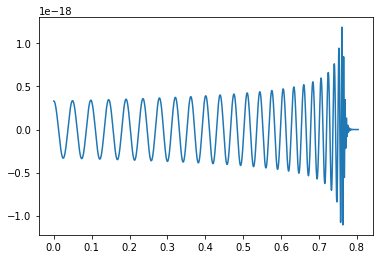

In [7]:
test_22 = hp_modes[(2,2)]
plt.plot(test_22.sample_times, test_22)

In [8]:
import makefun
# See https://smarie.github.io/python-makefun/

# A demonstration, here we are constructing a polynomial to fit with
def polynomial_term(x, a, n):
    # make a single term in a polynomial, given the coefficient and the power
    return a * x ** n

# This function will return a combined function
def make_polynomial_function(nmax=2):
    # Setup the function's desired call signature
    func_sig = "polynomial_function(x"
    for n in range(nmax):
        func_sig += f",a{n}"
    func_sig += ")"
    print(func_sig)
    
    # make the actual function itself, using *args
    def unwrapped_polynomial(x, **kwargs):
        polynomial = 0
        for key, val in kwargs.items():
            order = float(key[1:])
            polynomial += polynomial_term(x, val, order)
        return polynomial
            
    return makefun.create_function(func_sig, unwrapped_polynomial)

In [26]:
test_func = make_polynomial_function(nmax=2)

polynomial_function(x,a0,a1)


In [27]:
test = test_func(np.arange(15), 2, 2)

In [23]:
test_x_values = np.arange(100)
polynomial_to_fit = 4 + 5 * test_x_values + 3 * test_x_values ** 2 + 2 * test_x_values ** 3
print(polynomial_to_fit)

[      4      14      42     100     200     354     574     872    1260
    1750    2354    3084    3952    4970    6150    7504    9044   10782
   12730   14900   17304   19954   22862   26040   29500   33254   37314
   41692   46400   51450   56854   62624   68772   75310   82250   89604
   97384  105602  114270  123400  133004  143094  153682  164780  176400
  188554  201254  214512  228340  242750  257754  273364  289592  306450
  323950  342104  360924  380422  400610  421500  443104  465434  488502
  512320  536900  562254  588394  615332  643080  671650  701054  731304
  762412  794390  827250  861004  895664  931242  967750 1005200 1043604
 1082974 1123322 1164660 1207000 1250354 1294734 1340152 1386620 1434150
 1482754 1532444 1583232 1635130 1688150 1742304 1797604 1854062 1911690
 1970500]


In [32]:
fitting_func = make_polynomial_function(nmax=4)
from scipy.optimize import curve_fit
attempt_fit = curve_fit(fitting_func, test_x_values, polynomial_to_fit, [0,0,0,0])

polynomial_function(x,a0,a1,a2,a3)


In [33]:
print(attempt_fit)

(array([4., 5., 3., 2.]), array([[ 2.35620369e-25, -1.77564438e-26,  3.56892414e-28,
        -2.09233408e-30],
       [-1.77564438e-26,  1.82125418e-27, -4.14633815e-29,
         2.60174986e-31],
       [ 3.56892414e-28, -4.14633815e-29,  1.00913480e-30,
        -6.60320025e-33],
       [-2.09233408e-30,  2.60174986e-31, -6.60320025e-33,
         4.44659948e-35]]))
